# XGBoost回归分析

## $\S1$ Configuration & Data Preparation

In [29]:
# Configuration
## Loading Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


## Data Path
Path = "./Raw_Data_5.xlsx"
Dependent_Variable = "USD_index_Close"

## Param Grid
param_grid = {
    "model__n_estimators": [50, 100, 200, 400],
    "model__max_depth": [3, 5, 7, 9],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 1.0],                 # 行采样比例
    "model__colsample_bytree": [0.7, 1.0]           # 列采样比例
}

## CV Scoring
scoring = {
    ### sklearn默认maximize the score, so we use prefix "neg"
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}


In [30]:
# Data Preparation
## Loading Data
Data = pd.read_excel(Path, index_col="日期")
print("Data Size:", Data.shape)

## Data Split & Scale
### Split Features and Label
X = Data.drop(columns=[Dependent_Variable])
y = Data[[Dependent_Variable]]
# X,y = X.values, y.values

Data Size: (3209, 36)


In [31]:
### Split Train, Valid and Test Sets
train_size = int(len(Data) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size, :], y.iloc[train_size:, :]

#### Split Train Set into Tims Series
tsCV = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tsCV.split(X_train)):
    print(f"Fold {fold}: Train {len(train_idx)}, Test {len(test_idx)}")


Fold 0: Train 432, Test 427
Fold 1: Train 859, Test 427
Fold 2: Train 1286, Test 427
Fold 3: Train 1713, Test 427
Fold 4: Train 2140, Test 427


## $\S2$ Model Training & Predicting

In [32]:
## Generating Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist",
    )),
]
)

## Model Selection
### Grid_Search with Pipe on Grid using TimeSeriesSplit CV on Train Set
gsCV = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    cv = tsCV,
    scoring = scoring,
    refit = "R2",
    n_jobs = -1,
    verbose = 2
)
gsCV.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.7, 1.0], 'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [3, 5, ...], 'model__n_estimators': [50, 100, ...], ...}"
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'R2'
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [33]:
### printing best model
#### Best Hyper Parameters:
print("Grid Search 最佳参数: ", gsCV.best_params_)
print("对应的(CV平均)最优R2:", gsCV.best_score_)

#### CV Results:
result = pd.DataFrame(gsCV.cv_results_)
cols_to_show = ["mean_test_RMSE", "mean_test_MAE", "mean_test_R2"]
result["mean_test_MAE"] = -result["mean_test_MAE"]
result["mean_test_RMSE"] = -result["mean_test_RMSE"]
print(result[cols_to_show].sort_values(by="mean_test_R2", ascending=False).head(10))

Grid Search 最佳参数:  {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 9, 'model__n_estimators': 100, 'model__subsample': 0.7}
对应的(CV平均)最优R2: 0.018251359462738037
     mean_test_RMSE  mean_test_MAE  mean_test_R2
122        0.005042       0.003822      0.018251
114        0.005045       0.003829      0.017038
120        0.005051       0.003820      0.016315
112        0.005053       0.003826      0.015536
106        0.005054       0.003834      0.013212
116        0.005056       0.003837      0.011777
104        0.005062       0.003832      0.011312
124        0.005058       0.003832      0.011121
18         0.005066       0.003847      0.010552
108        0.005063       0.003848      0.009606


In [34]:
## Model Prediction
### 在gsCV中，refit已经选取了最优模型，Pipe在整个训练集上进行了重新训练
best_xgb = gsCV.best_estimator_
y_pred = best_xgb.predict(X_test)

Text(0.5, 1.0, 'XGBoost Regression Prediction')

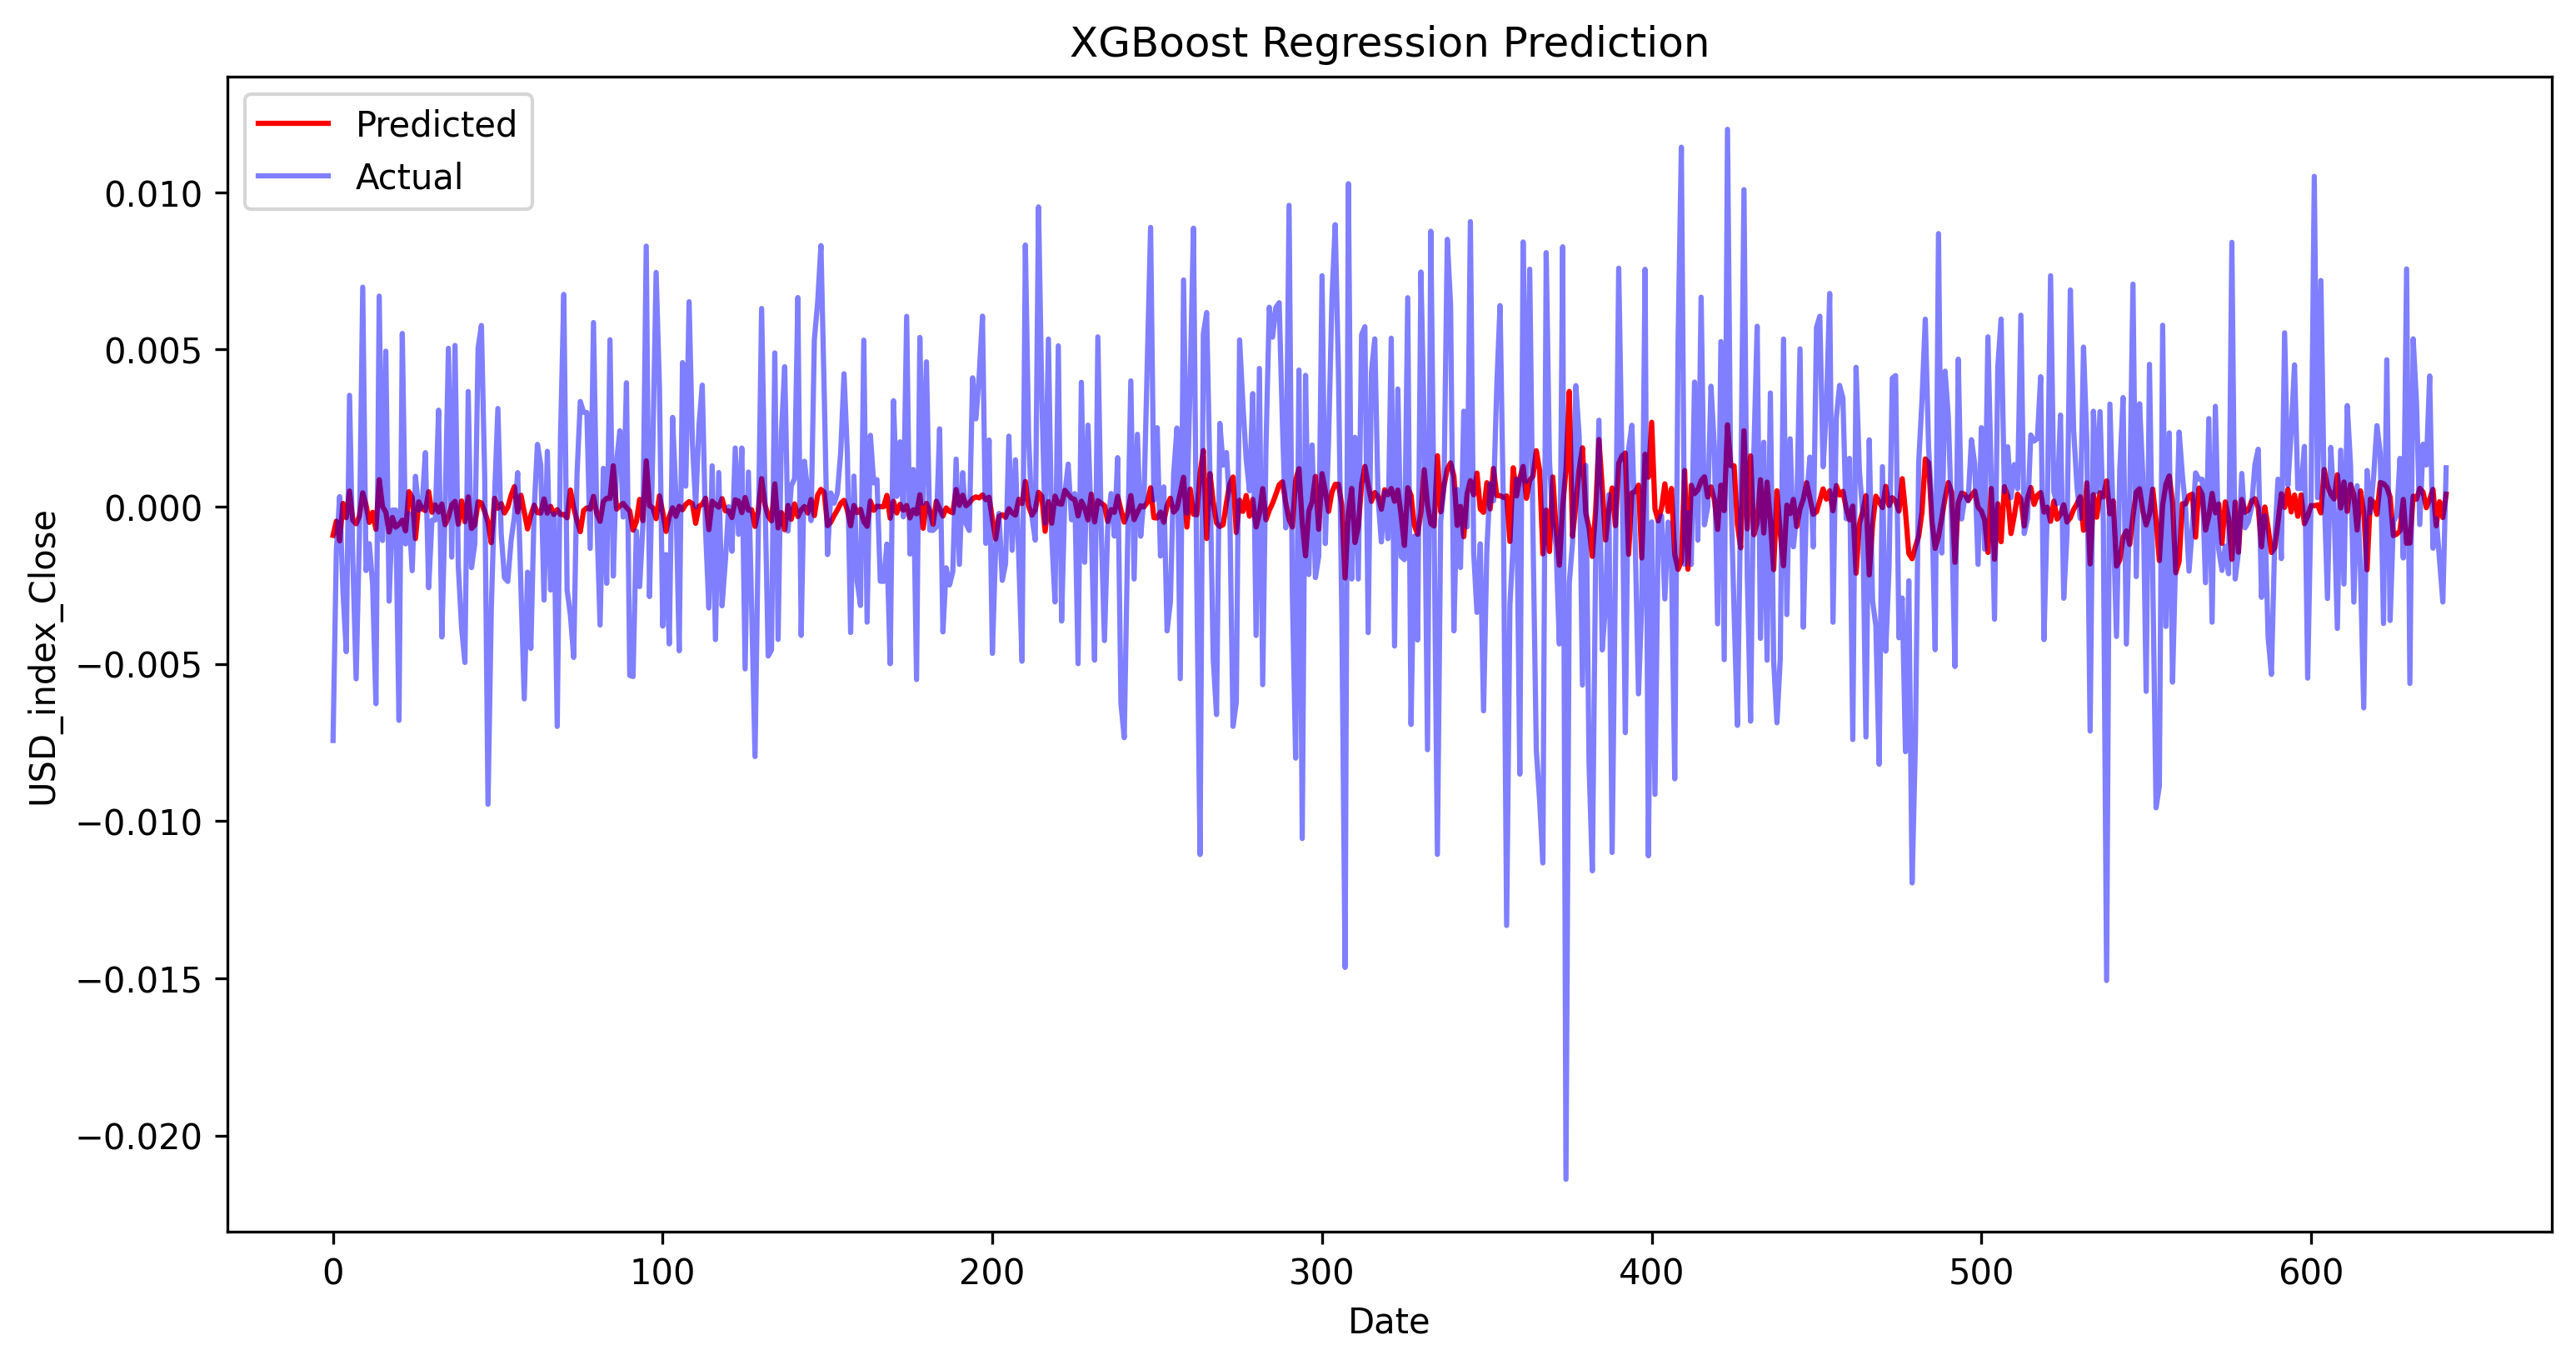

In [35]:
### Prediction Visualization
fig, ax1 = plt.subplots(figsize=(12,6), dpi=300)
ax1.plot(y_pred, label="Predicted", color="red")
ax1.plot(y_test.values, label="Actual", color="blue", alpha=0.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("USD_index_Close")
ax1.legend()
ax1.set_title("XGBoost Regression Prediction")

## $\S3$ Model Evaluation & Explanation

In [36]:
## Model Evaluation
# 4.2 计算测试集指标
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
## Campbell–Thompson OOS-R²:
oor2 = np.sum((y_test.values - y_pred)**2) / np.sum((y_test.values - np.mean(y_train))**2) 

print("=== 测试集表现 ===")
print(f"MAE  : {test_mae:.6f}")
print(f"RMSE  : {test_rmse:.6f}")
print(f"R^2  : {test_r2:.6f}")
print(f"Out of Sample R^2  : {test_r2:.6f}")

=== 测试集表现 ===
MAE  : 0.003228
RMSE  : 0.004257
R^2  : 0.018731
Out of Sample R^2  : 0.018731


In [ ]:
## Model Explanation
importances = best_xgb.named_steps["model"].feature_importances_
### Feature Importance
feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print(feature_importance.head(20))

USD_index_Close_Lag1     0.044695
US_10Y-GER_10Y_Open      0.042845
USD_index_Close_Std3     0.042144
CN_10Y-GER_10Y_Open      0.041837
VIX_Delta                0.040749
GER_index_Open           0.038590
USD_index_Close_Std7     0.036607
VIX_Open                 0.035153
CN_10Y-UK_10Y_Open       0.034957
USD_index_Close_Std14    0.032486
GER_10Y_Open             0.032124
USD_index_Close_Lag7     0.031022
GER_10Y-JP_10Y_Open      0.030563
JP_index_Open            0.029553
US_index_Open            0.029443
JP_10Y_Open              0.029108
GER_10Y-UK_10Y_Open      0.028572
US_10Y-CN_10Y_Open       0.027997
CN_10Y-JP_10Y_Open       0.027894
USD_index_Close_Lag4     0.027382
dtype: float32
